In [1]:
%cd /om/user/xboix/src/adversarial/Robustness

/om/user/xboix/src/adversarial/Robustness


In [2]:
experiment_name = "onelayer"
results_dir = '/vast/robustness/' + experiment_name + '/'

In [3]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import os 

import numpy as np
import pandas
    
import runs.config_experiments_onelayer as run
experiment_list = run.config_experiments(results_dir, create_json=False)

8085 config files created


In [4]:
name_attacks = ["linf_pgd","l2_pgd", "linf_fgsm", "l2_fgm"]

In [5]:
list_entries = []

for attack in [name_attacks[0]]:

    file_name = results_dir + experiment_list[0]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
    if not os.path.isfile(file_name):
        print("Missing!! " + file_name)
        continue
    with open(file_name, 'rb') as f:
        tmp = pickle.load(f)
                            
                            
    for cv_epsilon in list(tmp.keys()):
        # Hash table of parameters
        parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
                      "robust_training": {}, "type_robust": {}, "epsilon_pgd_training":{}}

        to_exclude = []
        experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
        for exp in experiment_list_tmp:
            if not exp['data_set'] == 67: 
                continue
            for kk in parameters.keys():
                if exp[kk] in parameters[kk]:
                    parameters[kk][exp[kk]].append(int(exp["model_name"]))
                else:
                    parameters[kk][exp[kk]] = [int(exp["model_name"])]


        # For all methods, do cross-val and create an entry of the results
        backbones = ['OneLayer', 'OneLayer+pgd']
        

        for backbone in backbones:
            for robust_training in [True, False]:
                if robust_training:
                    type_robust_trainings = ['linf','l1',"certificate"]
                else:
                    type_robust_trainings = ['none']
                for type_robust in type_robust_trainings:

                    if (backbone == 'Madry' and robust_training == True) or \
                        (backbone == 'CNN+clipping' and robust_training == False):
                        continue

                    if robust_training==False:
                        ids = list(set(parameters["backbone"][backbone]) & 
                                   set(parameters["robust_training"][False]))
                    else:
                        ids = list(set(parameters["backbone"][backbone]) & 
                               set(parameters["robust_training"][True])&
                              set(parameters["type_robust"][type_robust]))
             


                    if backbone == 'OneLayer+pgd' and robust_training == True:
                        continue

                    if ids == []:
                        continue
                    #print(ids)


                    # Cross-validation among learning rates and epsilons:
                    best_acc = -1
                    best_id = ids[0]
                    for id in ids:
                        file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
                        if not os.path.isfile(file_name):
                            print("Missing!! " + file_name)
                            continue
                        with open(file_name, 'rb') as f:
                            tmp = pickle.load(f)

                        acc = tmp[cv_epsilon]
                        if acc>best_acc:
                            best_id = id
                            best_acc = acc

                    if (robust_training == False) & (backbone=='OneLayer'):  
                        name_legend = 'vanilla'
                    elif backbone=='OneLayer+pgd':
                        name_legend = 'pgd'
                    else:
                        name_legend = type_robust

                    entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                            "backbone": experiment_list[best_id]['backbone'],
                            "robust_training": name_legend,
                            "epsilon": experiment_list[best_id]['epsilon'],
                            "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

                    dataset = "test"
                    entry["attack"] = attack
                    entry["experiment_id"] = best_id

                    with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                        attack + '.pkl', 'rb') as f:
                        tmp = pickle.load(f)

                    entry["test_epsilon"] = cv_epsilon
                    entry["accuracy"] =  100*tmp[cv_epsilon]
                    
                    with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + 'test' + '_' + 
                            'bound' + '.pkl', 'rb') as f:
                        tmp = pickle.load(f)
                    
                    entry["bound"] =  100*tmp[cv_epsilon]
                    list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 


In [6]:
df_results

,learning_rate,backbone,robust_training,epsilon,epsilon_pgd_training,attack,experiment_id,test_epsilon,accuracy,bound
0,0.0001,OneLayer,linf,0.0100,0.10,linf_pgd,26,0.0,47.617188,47.617188
1,0.0010,OneLayer,l1,10.0000,0.10,linf_pgd,55,0.0,49.062500,49.062500
2,0.0010,OneLayer,certificate,10.0000,0.10,linf_pgd,120,0.0,48.906250,48.906250
3,0.0001,OneLayer,vanilla,0.1000,0.10,linf_pgd,3,0.0,46.640625,46.640625
4,0.0010,OneLayer+pgd,pgd,10.0000,0.01,linf_pgd,85,0.0,46.601562,46.601562
...,...,...,...,...,...,...,...,...,...,...
60,0.1000,OneLayer,linf,0.0001,0.10,linf_pgd,5,1.0,9.648438,0.000000
61,0.1000,OneLayer,l1,100.0000,0.10,linf_pgd,135,1.0,9.648438,0.000000
62,0.0001,OneLayer,certificate,10000.0000,0.10,linf_pgd,161,1.0,10.546875,0.000000
63,0.1000,OneLayer,vanilla,0.1000,0.10,linf_pgd,0,1.0,5.976562,0.000000


In [7]:
ss = df_results.pivot(index=['robust_training'], columns=['test_epsilon'], values=['bound'])

In [8]:
ss

bound                                              \
test_epsilon        0.0000     0.0002     0.0005     0.0008     0.0010   
robust_training                                                          
certificate      48.906250  48.046875  46.875000  45.781250  44.960938   
l1               49.062500  48.203125  47.109375  46.054688  45.468750   
linf             47.617188  46.757812  45.000000  43.515625  42.265625   
pgd              46.601562  45.507812  43.281250  41.757812  40.625000   
vanilla          46.640625  45.117188  42.500000  39.921875  38.164062   

                                                                       \
test_epsilon        0.0015     0.0020     0.0030     0.0100    0.1000   
robust_training                                                         
certificate      43.359375  41.679688  38.476562  16.757812  3.046875   
l1               43.554688  41.679688  38.515625  15.742187  1.132812   
linf             39.804688  36.796875  32.460938   5.546875  0.000000   
pgd              38.164062  34.960938  29.570312  15.742187  0.000000   
vanilla          33.671875  29.570312  21.328125   0.664062  0.000000   

                                          
test_epsilon        0.3000 0.5000 1.0000  
robust_training                           
certificate      10.546875    0.0    0.0  
l1                0.000000    0.0    0.0  
linf              0.000000    0.0    0.0  
pgd               0.000000    0.0    0.0  
vanilla           0.000000    0.0    0.0

In [9]:
def bold_extreme_values(data, format_string="%.2f", max_=True):
    if max_:
        extrema = data != data.max()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

for col in ss.columns.get_level_values(0).unique():
    ss[col] = ss[col].apply(lambda data : bold_extreme_values(data),axis=0)




In [10]:
ss

bound                                  \
test_epsilon             0.0000          0.0002          0.0005   
robust_training                                                   
certificate               48.91           48.05           46.88   
l1               \textbf{49.06}  \textbf{48.20}  \textbf{47.11}   
linf                      47.62           46.76           45.00   
pgd                       46.60           45.51           43.28   
vanilla                   46.64           45.12           42.50   

                                                                 \
test_epsilon             0.0008          0.0010          0.0015   
robust_training                                                   
certificate               45.78           44.96           43.36   
l1               \textbf{46.05}  \textbf{45.47}  \textbf{43.55}   
linf                      43.52           42.27           39.80   
pgd                       41.76           40.62           38.16   
vanilla                   39.92           38.16           33.67   

                                                                 \
test_epsilon             0.0020          0.0030          0.0100   
robust_training                                                   
certificate      \textbf{41.68}           38.48  \textbf{16.76}   
l1               \textbf{41.68}  \textbf{38.52}           15.74   
linf                      36.80           32.46            5.55   
pgd                       34.96           29.57           15.74   
vanilla                   29.57           21.33            0.66   

                                                                              
test_epsilon            0.1000          0.3000         0.5000         1.0000  
robust_training                                                               
certificate      \textbf{3.05}  \textbf{10.55}  \textbf{0.00}  \textbf{0.00}  
l1                        1.13            0.00  \textbf{0.00}  \textbf{0.00}  
linf                      0.00            0.00  \textbf{0.00}  \textbf{0.00}  
pgd                       0.00            0.00  \textbf{0.00}  \textbf{0.00}  
vanilla                   0.00            0.00  \textbf{0.00}  \textbf{0.00}

In [199]:
print(ss.to_latex(index=True, bold_rows= False,escape=False))  

\begin{tabular}{llllllllllllll}
\toprule
{} & \multicolumn{13}{l}{bound} \\
test_epsilon &          0.0000 &          0.0002 &          0.0005 &          0.0008 &          0.0010 &          0.0015 &          0.0020 &          0.0030 &          0.0100 &         0.1000 &          0.3000 &         0.5000 &         1.0000 \\
robust_training &                 &                 &                 &                 &                 &                 &                 &                 &                 &                &                 &                &                \\
\midrule
certificate     &           48.91 &           48.05 &           46.88 &           45.78 &           44.96 &           43.36 &  \textbf{41.68} &           38.48 &  \textbf{16.76} &  \textbf{3.05} &  \textbf{10.55} &  \textbf{0.00} &  \textbf{0.00} \\
l1              &  \textbf{49.06} &  \textbf{48.20} &  \textbf{47.11} &  \textbf{46.05} &  \textbf{45.47} &  \textbf{43.55} &  \textbf{41.68} &  \textbf{38.52} &       

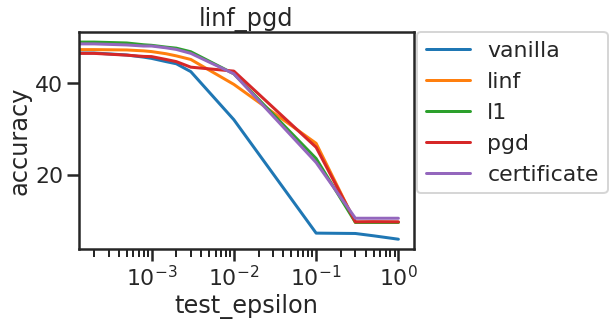

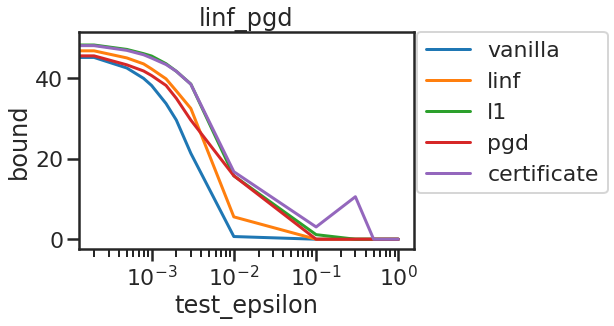

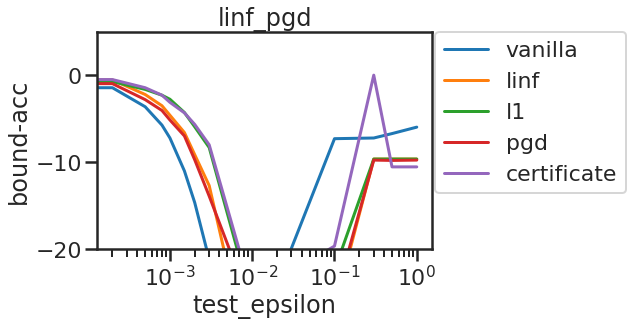

In [200]:
for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="robust_training", hue_order=['vanilla', 'linf', 'l1','pgd','certificate'], palette="tab10",
                 data=df_results[(df_results.attack==attack)]).set_title(attack)
    plt.xscale('log')
    #plt.ylim([0,55])
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="bound",
                 hue="robust_training", hue_order=['vanilla', 'linf', 'l1','pgd','certificate'], palette="tab10",
                 data=df_results[(df_results.attack==attack)]).set_title(attack)
    plt.xscale('log')
    #plt.ylim([0,55])
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    
df_results['bound-acc'] = df_results['bound'] - df_results['accuracy']
for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="bound-acc",
                 hue="robust_training", hue_order=['vanilla', 'linf', 'l1','pgd','certificate'], palette="tab10",
                 data=df_results[(df_results.attack==attack)]).set_title(attack)
    plt.xscale('log')
    plt.ylim([-20,5])
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [17]:
#UCI
if not os.path.isfile('/vast/robustness/datasets/UCI/datasets_info.csv'):
    import json
    datasets = []
    for data_set in range(20,66):
        with open('/vast/robustness/configs_datasets/' + str(data_set) + '.json') as config_file:
            config = json.load(config_file)
            tmpX = np.shape(np.genfromtxt('/vast/robustness/datasets/UCI/imp_' + config["name_file"] 
                                 + '_' + "trainX.csv", delimiter=','))
            config["num_examples"] = tmpX[0]
            config["num_features"] = tmpX[1]
            datasets.append(config)
    df = pd.DataFrame(datasets) 
    df.to_csv('/vast/robustness/datasets/UCI/datasets_info.csv')
else:
    df = pd.read_csv('/vast/robustness/datasets/UCI/datasets_info.csv')

name_attacks = ["linf_pgd","l2_pgd", "linf_fgsm", "l2_fgm"]

list_entries = []
for cv_epsilon in range(13):
    
    for idx_dd in range(20,66):

        dd = df[df.dataset_id==idx_dd].iloc[0]
        # Hash table of parameters
        parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
                      "robust_training": {}, "l1_robustness": {}, "certificate": {}, "epsilon_pgd_training":{}}


        to_exclude = []
        experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
        for exp in experiment_list_tmp:
            if not exp["data_set"]==dd.dataset_id:
                continue

            for kk in parameters.keys():
                if exp[kk] in parameters[kk]:
                    parameters[kk][exp[kk]].append(int(exp["model_name"]))
                else:
                    parameters[kk][exp[kk]] = [int(exp["model_name"])]


        # For all methods, do cross-val and create an entry of the results
        backbones = ['OneLayer', 'OneLayer+pgd']
        robust_trainings = ['none','linf','l1', 'certificate']

        for backbone in backbones:
            for robust_training in robust_trainings:
                if (backbone == 'Madry' and robust_training == True) or \
                    (backbone == 'CNN+clipping' and robust_training == False):
                    continue

                
                    
                if robust_training=='none':
                    ids = list(set(parameters["backbone"][backbone]) & 
                               set(parameters["robust_training"][False]))
                elif robust_training=='linf':
                    ids = list(set(parameters["backbone"][backbone]) & 
                               set(parameters["robust_training"][True])&
                              set(parameters["l1_robustness"][False])&
                            set(parameters["certificate"][False]))
                elif robust_training=='l1':
                    ids = list(set(parameters["backbone"][backbone]) & 
                            set(parameters["robust_training"][True])&
                            set(parameters["l1_robustness"][True])&
                            set(parameters["certificate"][False]))
                elif robust_training=='certificate':
                    ids = list(set(parameters["backbone"][backbone]) & 
                            set(parameters["robust_training"][True])&
                            set(parameters["l1_robustness"][True])&
                            set(parameters["certificate"][True]))
                    
                if backbone == 'MLP+pgd' and robust_training == True:
                    continue

                if ids == []:
                    continue
                #print(ids)

                # Cross-validation among learning rates and epsilons:
                best_acc = 0.0
                best_id = -1
                for id in ids:
                    acc = 0.0
                    for attack in [name_attacks[0]]:
                        file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
                        if not os.path.isfile(file_name):
                            print("Missing!! " + file_name)
                            continue
                        with open(file_name, 'rb') as f:
                            tmp = pickle.load(f)

                        ave_acc = 0.0
                        for test_epsilon in list(tmp.keys())[cv_epsilon:cv_epsilon+1]:
                            ave_acc += tmp[test_epsilon]
                        ave_acc = ave_acc / len(tmp.keys())
                        acc += ave_acc
                    acc = acc / 2
                    if acc>best_acc:
                        best_id = id
                        best_acc = acc

                entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                        "backbone": experiment_list[best_id]['backbone'],
                        "robust_training": robust_training,
                        "epsilon": experiment_list[best_id]['epsilon'],
                        "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training'],
                        "num_features": dd.num_features,
                        "num_examples": dd.num_examples,
                        "dataset_name": dd.name_file}

                dataset = "test"
                for attack in [name_attacks[0]]:
                    entry["dataset"] = dd.dataset_id - 20
                    entry["attack"] = attack
                    entry["experiment_id"] = best_id

                    if not backbone == 'Madry':
                        with open(results_dir + experiment_list[best_id]['model_name'] + 
                                  '/results/training_time.pkl', 'rb') as f:
                            tmp = pickle.load(f)
                        entry["images_per_second"] = np.mean(tmp) 
                        entry["std_images_per_second"] = np.std(tmp) 

                    with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                        attack + '.pkl', 'rb') as f:
                        tmp = pickle.load(f)

                    for test_epsilon in list(tmp.keys())[cv_epsilon:cv_epsilon+1]:
                        entry["test_epsilon"] = test_epsilon
                        entry["accuracy"] =  100*tmp[test_epsilon]
                        list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 




Missing!! /vast/robustness/onelayer/1108/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2271/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2425/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2900/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3244/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3338/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3583/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3984/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4462/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4564/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4684/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5416/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5886/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5887/results/acc_val_linf_pgd.pkl
Missing!! /vast/robu

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Missing!! /vast/robustness/onelayer/7934/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/7935/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/1108/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2271/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2425/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2900/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3244/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3338/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3583/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3984/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4462/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4564/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4684/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5416/results/acc_val_linf_pgd.pkl
Missing!! /vast/robu

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Missing!! /vast/robustness/onelayer/7934/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/7935/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/1108/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2271/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2425/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2900/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3244/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3338/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3583/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3984/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4462/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4564/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4684/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5416/results/acc_val_linf_pgd.pkl
Missing!! /vast/robu

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Missing!! /vast/robustness/onelayer/7934/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/7935/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/1108/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2271/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2425/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2900/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3244/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3338/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3583/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3984/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4462/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4564/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4684/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5416/results/acc_val_linf_pgd.pkl
Missing!! /vast/robu

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Missing!! /vast/robustness/onelayer/7934/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/7935/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/1108/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2271/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2425/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2900/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3244/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3338/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3583/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3984/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4462/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4564/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4684/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5416/results/acc_val_linf_pgd.pkl
Missing!! /vast/robu

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Missing!! /vast/robustness/onelayer/7934/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/7935/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/1108/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2271/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2425/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2900/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3244/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3338/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3583/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/3984/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4462/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4564/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/4684/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5416/results/acc_val_linf_pgd.pkl
Missing!! /vast/robu

Missing!! /vast/robustness/onelayer/5416/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5886/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/5887/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/6009/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/6822/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/6873/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/6874/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/7491/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/7934/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/7935/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/1108/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2271/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2425/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/onelayer/2900/results/acc_val_linf_pgd.pkl
Missing!! /vast/robu

In [18]:
set(df_results[df_results.dataset==1].attack)

{'linf_pgd'}

In [19]:

win_pgd = []
win_robust = []

df_final = df_results.groupby(['backbone', 'robust_training', 'dataset','test_epsilon']).mean().reset_index()

df_final["winner"] = False
df_final["tie"] = False
df_final["accuracy_normal"] = 0

plot_entries = []
for attack in name_attacks:
    list(set(df_final.test_epsilon))
    for cv_epsilon in list(set(df_final.test_epsilon)):
        for idx_dd in range(0,46):
            xx = df_final[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)]
            df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon),
                         "accuracy_normal"] = xx.accuracy / xx.accuracy.max()
            winners = df_final[ (df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)
                               & (df_final.accuracy_normal >= 0.95)]
            #if len(winners)==1:    
            df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal>=0.95), "winner"] = True
            df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal<0.95), "winner"] = False

            #else:
            #    df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal >=  0.95), "tie"] = True
        
        
        plot_entries.append({"epsilon": cv_epsilon,
                        "backbone": 'pgd',
                        "attack": attack,
                        "num_wins": len(list(df_final[(df_final.backbone=='OneLayer+pgd') & (df_final.robust_training == 'none')&(df_final.test_epsilon==cv_epsilon)
                                     & (df_final.winner)].dataset))})
        plot_entries.append({"epsilon": cv_epsilon,
                "backbone": 'vanilla',
                "attack": attack,
                "num_wins": len(list(df_final[(df_final.backbone=='OneLayer') & (df_final.robust_training == 'none')&(df_final.test_epsilon==cv_epsilon)
                             & (df_final.winner)].dataset))})
        
        plot_entries.append({"epsilon": cv_epsilon,
                "backbone": 'l1',
                "attack": attack,
                "num_wins": len(list(df_final[(df_final.backbone=='OneLayer') & (df_final.robust_training == 'l1')&(df_final.test_epsilon==cv_epsilon)
                             & (df_final.winner)].dataset))})
        plot_entries.append({"epsilon": cv_epsilon,
                "backbone": 'linf',
                "attack": attack,
                "num_wins": len(list(df_final[(df_final.backbone=='OneLayer') & (df_final.robust_training == 'linf')&(df_final.test_epsilon==cv_epsilon)
                             & (df_final.winner)].dataset))})
        
        plot_entries.append({"epsilon": cv_epsilon,
                "backbone": 'certificate',
                "attack": attack,
                "num_wins": len(list(df_final[(df_final.backbone=='OneLayer') & (df_final.robust_training == 'certificate')&(df_final.test_epsilon==cv_epsilon)
                             & (df_final.winner)].dataset))})
                    
        
        win_pgd.append(len(list(df_final[(df_final.backbone=='OneLayer+pgd') & (df_final.robust_training == 'none')&(df_final.test_epsilon==cv_epsilon)
                                     & (df_final.winner)].dataset)))
        win_robust.append(len(list(df_final[(df_final.backbone=='OneLayer') & (df_final.robust_training == 'linf')&(df_final.test_epsilon==cv_epsilon)
                                        & (df_final.winner)].dataset)))
df_plot = pd.DataFrame.from_dict(plot_entries) 

#winner_pgd_list.append(win_pgd)
#winner_robust_list.append(win_robust)

In [20]:
df_plot

,epsilon,backbone,attack,num_wins
0,0.0000,pgd,linf_pgd,44
1,0.0000,vanilla,linf_pgd,40
2,0.0000,l1,linf_pgd,40
3,0.0000,linf,linf_pgd,46
4,0.0000,certificate,linf_pgd,40
...,...,...,...,...
255,0.0005,pgd,l2_fgm,44
256,0.0005,vanilla,l2_fgm,34
257,0.0005,l1,l2_fgm,34
258,0.0005,linf,l2_fgm,44


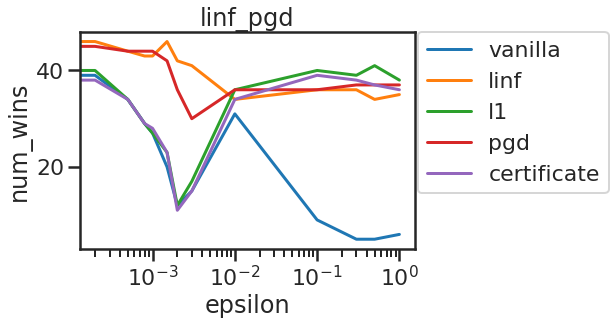

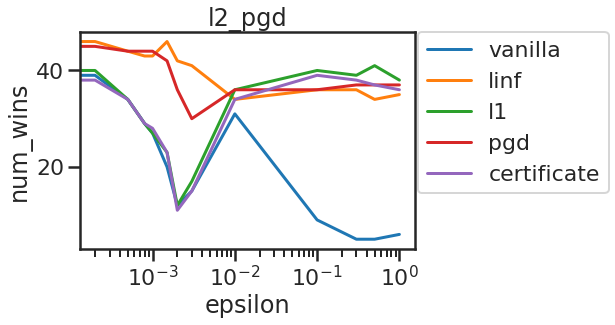

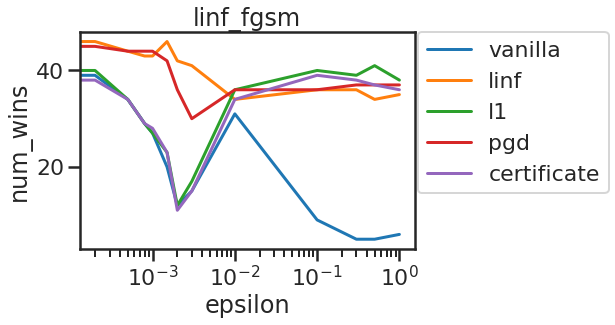

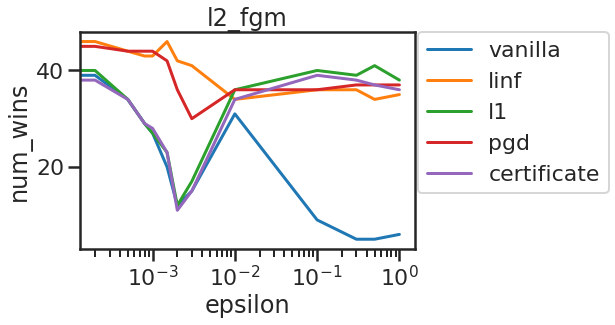

In [21]:
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="epsilon", y="num_wins",
                 hue="backbone",  hue_order=['vanilla', 'linf', 'l1','pgd','certificate'],  palette="tab10", 
                 data=df_plot[(df_plot.attack==attack)]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

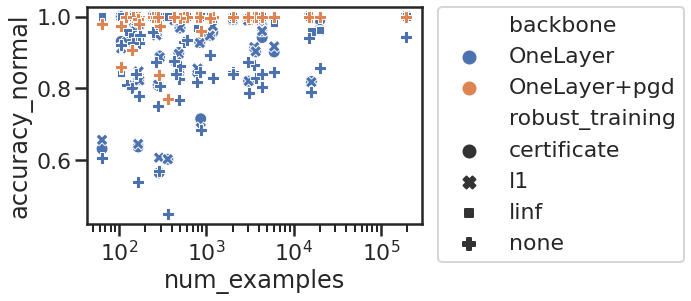

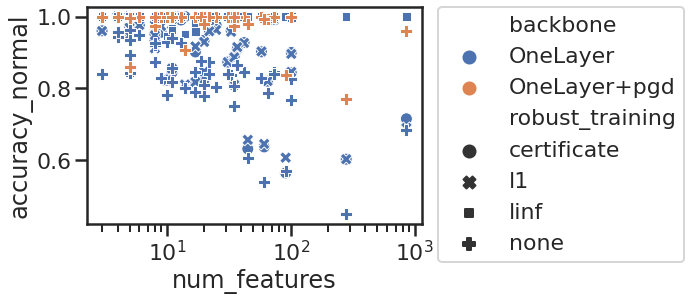

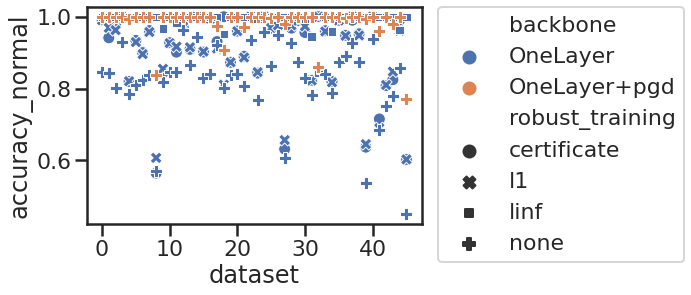

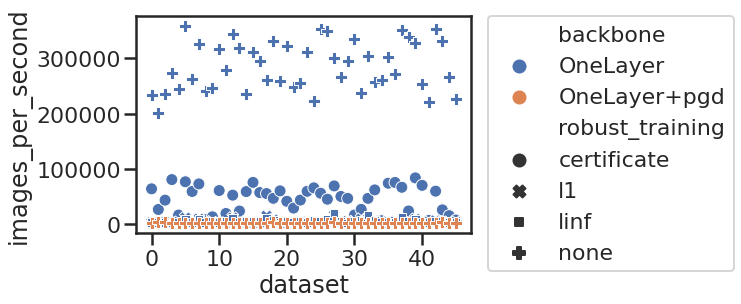

In [25]:
df_final = df_results.groupby(['backbone', 'robust_training', 'dataset']).mean().reset_index()
for idx_dd in range(0,46):
    xx = df_final[df_final.dataset == idx_dd]
    df_final.loc[df_final.dataset == idx_dd, "accuracy_normal"] = xx.accuracy / xx.accuracy.max()

        
plt.figure()
sns.scatterplot(data=df_final, x="num_examples",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')

plt.figure()
sns.scatterplot(data=df_final, x="num_features",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')

plt.figure()
sns.scatterplot(data=df_final, x="dataset",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
sns.scatterplot(data=df_final[~((df_final.robust_training==False)&(df_final.backbone=='MLP'))], 
                x="dataset",y="images_per_second",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [12]:
list_entries = []

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:

    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

# For all methods, do cross-val and create an entry of the results
backbones = ['OneLayer', 'OneLayer+pgd']
robust_trainings = [True,False]

for backbone in backbones:
    for robust_training in robust_trainings:
        
        if backbone == 'OneLayer+pgd':
            eps = parameters['epsilon_pgd_training'].keys()
        else:
            eps = parameters['epsilon'].keys()
            
        for ep in eps: #for each epsilon in training:
            
            if (backbone == 'Madry' and robust_training == True) or \
                (backbone == 'CNN+clipping' and robust_training == False):
                continue

            ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))

            if backbone == 'OneLayer+pgd':
                ids = list(set(ids) & set(parameters["epsilon_pgd_training"][ep]) )
            else:
                ids = list(set(ids) & set(parameters["epsilon"][ep]) )
            
            if ids == []:
                continue

            # Cross-validation among learning rates and epsilons:
            best_acc = -1.0
            best_id = ids[0]
            for id in ids:
                file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + name_attacks[0] + '.pkl'
                if not os.path.isfile(file_name):
                    print("Missing!! " + file_name)
                    continue
                with open(file_name, 'rb') as f:
                    tmp = pickle.load(f)

                acc = tmp[0.0]
                if acc>best_acc:
                    best_id = id
                    best_acc = acc

            entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                    "backbone": experiment_list[best_id]['backbone'],
                    "robust_training": experiment_list[best_id]['robust_training'],
                    "epsilon": experiment_list[best_id]['epsilon'],
                    "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

            dataset = "test"
            entry["attack"] = name_attacks[0]
            entry["experiment_id"] = best_id

            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                name_attacks[0] + '.pkl', 'rb') as f:
                tmp = pickle.load(f)


            entry["train_epsilon"] = ep
            entry["accuracy"] =  100*tmp[0.0]
            list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 

Missing!! /vast/robustness/onelayer/134/results/acc_val_linf_pgd.pkl


In [13]:
df_results

,learning_rate,backbone,robust_training,epsilon,epsilon_pgd_training,attack,experiment_id,train_epsilon,accuracy
0,0.00010,OneLayer,True,0.10000,0.10000,linf_pgd,125,0.10000,47.265625
1,0.00010,OneLayer,True,0.00010,0.10000,linf_pgd,56,0.00010,46.718750
2,0.00010,OneLayer,True,0.00001,0.10000,linf_pgd,24,0.00001,46.757812
3,0.00010,OneLayer,True,0.00100,0.10000,linf_pgd,58,0.00100,46.757812
4,0.00010,OneLayer,True,0.01000,0.10000,linf_pgd,26,0.01000,47.617188
5,0.00010,OneLayer,True,1.00000,0.10000,linf_pgd,126,1.00000,47.031250
6,0.00100,OneLayer,True,10.00000,0.10000,linf_pgd,120,10.00000,48.906250
7,0.00010,OneLayer,False,0.10000,0.10000,linf_pgd,3,0.10000,46.640625
8,0.00100,OneLayer+pgd,False,10.00000,0.10000,linf_pgd,86,0.10000,44.960938
9,0.00010,OneLayer+pgd,False,10.00000,0.00010,linf_pgd,88,0.00010,46.796875


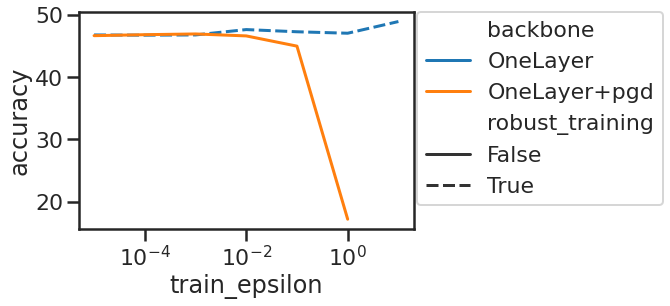

In [14]:
plt.figure()
sns.lineplot(x="train_epsilon", y="accuracy",
             hue="backbone",  style='robust_training', palette="tab10",
             data=df_results[(df_results.attack==name_attacks[0])])
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

[1536, 1543, 1550, 1522, 1529]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


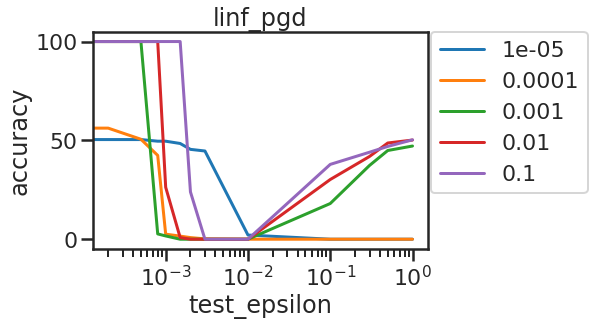

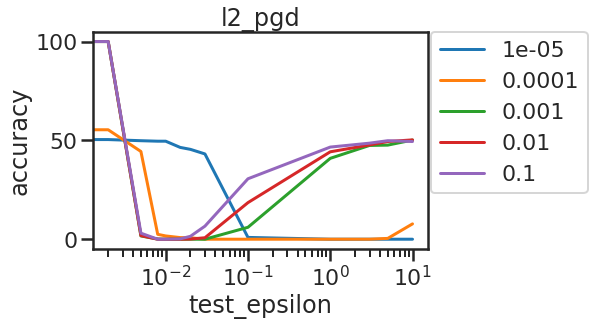

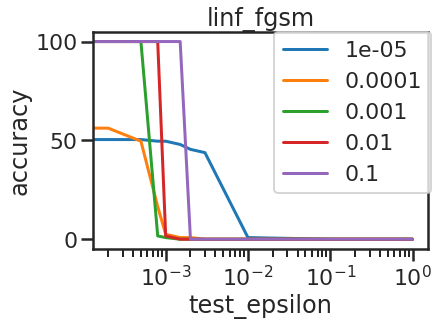

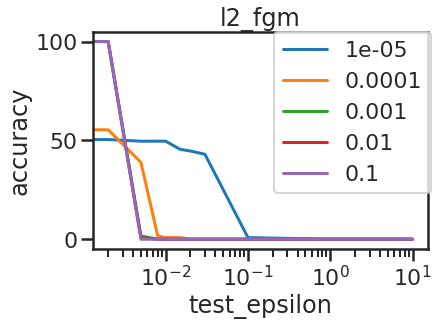

In [44]:
# Display learning rate impact
epsilon = 1e-3
backbone = 'OneLayer'
robust_training = True
epsilon_pgd_training = 0.1
type_robust_training = 'l1'

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "l1_robustness": {}, "certificate": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:
    if not exp['data_set'] == 26: 
        continue

    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]
                    
if robust_training:
    if type_robust_training=='linf':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][False])&
                set(parameters["certificate"][False])&
                set(parameters["epsilon"][epsilon]))
    elif type_robust_training=='l1':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][True])&
                set(parameters["certificate"][False])&
                set(parameters["epsilon"][epsilon]))
    elif type_robust_training=='certificate':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][True])&
                set(parameters["certificate"][True])&
                set(parameters["epsilon"][epsilon]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]) & 
            set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))

print(ids)
list_entries = []
for id in ids:
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="learning_rate",  palette="tab10",
                 data=df[df.dataset=='test'][df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


In [30]:
# Display epsilon
backbones = ['MLP+pgd']
robust_training = False
epsilon_pgd_training = 1e-3

list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

            
        if robust_training:
            ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
        else:
            ids = list(set(parameters["backbone"][backbone]) &
                    set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
            
        if len(ids)==0:
            continue
            
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:2]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc
                
        print(best_id)
        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="epsilon",  style='backbone', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


KeyError: 'MLP+pgd'

[1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399]
1376
[1365, 1366, 1367, 1368, 1369]
1366
[1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407]
1408


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


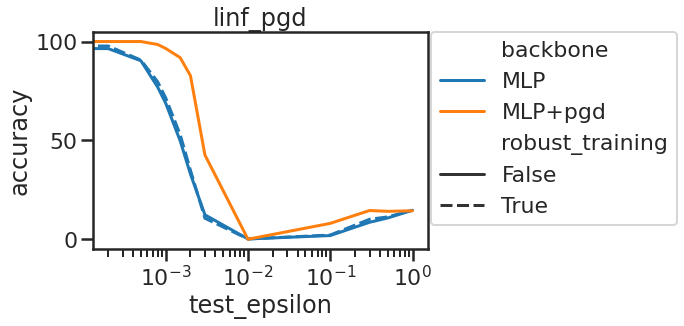

<Figure size 432x288 with 0 Axes>

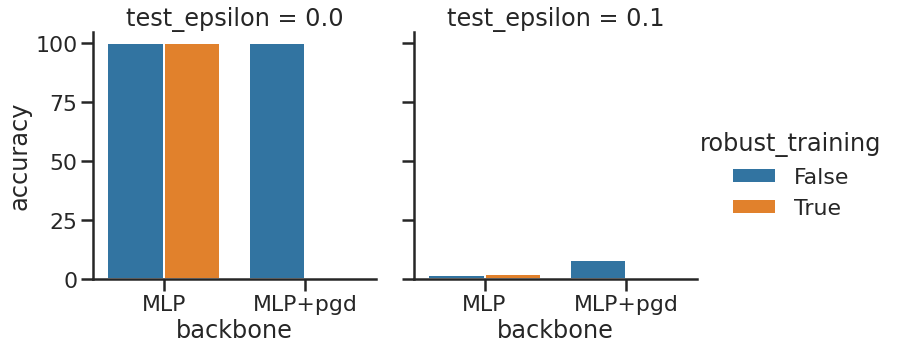

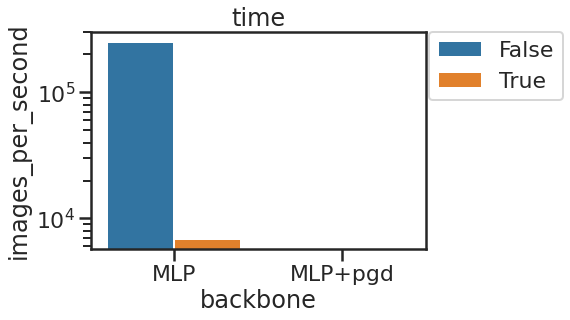

In [60]:
# Display best
backbones = ['MLP', 'MLP+pgd']
robust_trainings = [True,False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:
        if (backbone == 'Madry' and robust_training == True) or \
            (backbone == 'CNN+clipping' and robust_training == False):
            continue
            
        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))
        
        if backbone == 'MLP+pgd' and robust_training == True:
            continue
            
        if ids == []:
            continue
        print(ids)
        
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            #if (experiment_list[id]['backbone'] == 'CNN+pgd') and experiment_list[id]["epsilon_pgd_training"] == 0.3:
            #    continue 
            acc = 0.0
            for attack in [name_attacks[0]]:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[0:1]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            
            if not backbone == 'Madry':
                with open(results_dir + experiment_list[best_id]['model_name'] + 
                          '/results/training_time.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                entry["images_per_second"] = np.mean(tmp) 
                entry["std_images_per_second"] = np.std(tmp) 
                
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                  
df = pd.DataFrame.from_dict(list_entries) 

for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df[(df.test_epsilon == 0)| (df.test_epsilon == epsilon)][df.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [ ]:
df[(df.test_epsilon==0.01)&(df.attack=='linf_pgd')]

In [87]:
df[df.backbone=="Madry"][df.attack=="linf_pgd"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
218,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN
270,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN


In [107]:
df[df.backbone=="Madry"][df.attack=="linf_fgsm"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
244,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
296,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
